# Resampling with extreme values: Lifting mechanism

Prepared for:
Fracture density reconstruction using direct sampling multiple-point statistics and extreme value theory. Applied Computing and Geosciences. Ref.: ACAGS-D-23-00073

Authors: Tanaka, A.P.B., Renard, P., and Straubhaar, J. (2024)

Based in:
- Opitz, T., Allard, D., and Mariethoz, G. (2021), *Semi-parametric resampling with extremes*, Spatial Statistics 42, p. 100445, doi: https://doi.org/10.1016/j.spasta.2020.100445

## Import packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import scipy.stats as stats
import geone as gn
import source.zfunc as zfunc #load function to build the univariate density model

C:\Users\burgoaa\Anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Initial data set

In [2]:
#Load data set with geone
im = gn.img.readImageGslib('data/syn_well_p10.gslib', missing_value=-9999999)

In [3]:
#Get all values of the image
x = im.val[0].reshape(-1) # extract variable of index 0: P10
x = x[~np.isnan(x)]       

### Kernel density estimate (KDE), cumulative distribution function (CDF)
For each cell index $i$, compute the KDE.

In [4]:
# Divide the initial series, in several ones ("realizations") of same length
real_size = 62
x = x[:len(x)-len(x)%real_size] # remove last entries s.t. the length is a multiple of 'real_size'
x_real = x[:len(x)-len(x)%real_size].reshape(-1, real_size)
nreal = x_real.shape[0]

### Model distribution with GPD queue (at right)

In [5]:
# Compute quantiles
quant = (0., 0.5, 0.75, 0.9, 0.95, 1.)
quant_name = [f'{100*q:.3g}%' for q in quant]

x_real_quant = np.quantile(x_real, q=quant, axis=0)

# Compute global statistics (all cells and all realizations together)
x_global_kde = stats.gaussian_kde(x)
x0_global = x_real.min()
x1_global = x_real.max()
x_global_cdf, x_global_cdf_inv = zfunc.cdf_from_kde(x_global_kde, x0_global, x1_global)

In [6]:
# Parameter: mass of right queue of distribution modeled with a GPD
p_marg = 0.01

x_global_marg, x_global_gpd = zfunc.gpd_queue(x, x_global_kde, x_global_cdf, x_global_cdf_inv, x0_global, x1_global,
                                        pmarg=p_marg, right_queue=True, method='MLE') #using maximum likelihood estimator

x_global_f_hat = zfunc.pdf_model(x_global_kde, None, None, None, p_marg, x_global_marg, x_global_gpd)
x_global_F_hat, x_global_F_hat_inv = zfunc.cdf_model(x_global_cdf, x_global_cdf_inv, None, None, None, p_marg, x_global_marg, x_global_gpd)

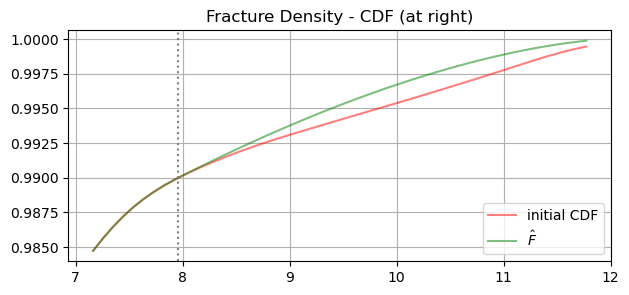

In [7]:
# Plot modeled CDF - global
tt = np.linspace(x_global_marg-0.1*(x_global_marg-x0_global), max(x))
plt.figure(figsize=(7,3))
plt.plot(tt, x_global_cdf(tt), c='red', ls='solid', alpha=.5, label='initial CDF')
plt.plot(tt, x_global_F_hat(tt), c='green', ls='solid', alpha=.5, label='$\hat F$')
plt.axvline(x=x_global_marg, c='gray', ls='dotted')
plt.legend()
plt.grid()
plt.title('Fracture Density - CDF (at right)')
plt.show()

### Transormation - global (using global CDF model)

In [8]:
xP_global_real = 1/(1.-x_global_F_hat(x_real))
xU_global_real = x_global_F_hat(x_real) - 1.

# Compute marginal thresholds xP_global_marg, xU_global_marg corresponding to x_global_marg
xP_global_marg = 1/(1.0 - x_global_F_hat(x_global_marg))
xU_global_marg = x_global_F_hat(x_global_marg) - 1.0

### Summary statistics / aggregation functional "in transformed space"

In [9]:
# r function (aggregation functional on realization in Pareto scale)
def rfunc(x):
    return np.max(x)

In [10]:
# Aggregation functional on each real in Pareto scale
r_xP_global_real = np.array([rfunc(xP) for xP in xP_global_real])

# "In uniform scale"
v_global_real = -1/r_xP_global_real

In [11]:
# Set threshold for extremes (q and u=-1/q)
r_xP_global_thresh = np.quantile(r_xP_global_real, 0.7) # q above (can be changed)
v_global_thresh = -1/r_xP_global_thresh                 # u above

In [12]:
# Estimation of theta_r
theta_global_r = - np.mean(v_global_real > v_global_thresh) / v_global_thresh
theta_global_r = np.mean(r_xP_global_real > r_xP_global_thresh) * r_xP_global_thresh

In [13]:
# Identify the realizations to be lifted
# where "observed value" v are greater than the threshod v_global_thresh
flag_lifted_global_real = v_global_real > v_global_thresh # vector of boolean of length nreal
nlifted_global_real = np.sum(flag_lifted_global_real) # number of realization to be lifted

# Set the bounds v1 <= v2 <=0 (bounds u1, u2 above)
# to define a uniform distribution in [v1, v2] to draw new value for v
v1 = 0.8 * v_global_thresh
v2 = -1.e-6 

# Draw new value for v, for every realization to be lifted
np.random.seed(444)
v_new_global_real = np.copy(v_global_real)
v_new_global_real[flag_lifted_global_real] = v1 + np.random.random(size=nlifted_global_real)*(v2 - v1)

# Set scaling factor, for every realization
s_global_real = v_new_global_real / v_global_real

# Set split threshold, choose:
xU_global_split = max(-0.25, -1/s_global_real.max()) * np.ones(real_size)

# Lift and post-process realizations
xU_new_global_real = np.copy(xU_global_real)

for id in range(nreal):
    # check if the realization has to be lifted
    if not flag_lifted_global_real[id]:
        continue
    # split
    i1 = np.where(xU_global_real[id] <= xU_global_split)
    i2 = np.where(xU_global_real[id] > xU_global_split)
    # lift on i2:
    xU_new_global_real[id, i2] = s_global_real[id] * xU_global_real[id, i2]
    # post-process on i1:
    xU_new_global_real[id, i1] = -1.0 + (1.0 + s_global_real[id]*xU_global_split[i1])/(1.0 + xU_global_split[i1]) * (xU_global_real[id, i1] + 1.)

# Back-transform into initial space
x_new_global_real = x_global_F_hat_inv(1.0 + xU_new_global_real)

In [14]:
# Aggregation functional on each new real 
# ... in "Pareto scale"
xP_new_global_real = -1/xU_new_global_real
r_xP_new_global_real = np.array([rfunc(xP) for xP in xP_new_global_real])
# ... in "Uniform scale" (must be recompute because of splitting and post-processing)
v_new_global_real = -1/r_xP_new_global_real

In [15]:
# Get the indices of the realizations with extremes, i.e. realizations that have been lifted
id_lifted_global_real = np.where(flag_lifted_global_real)[0]

### Plot results

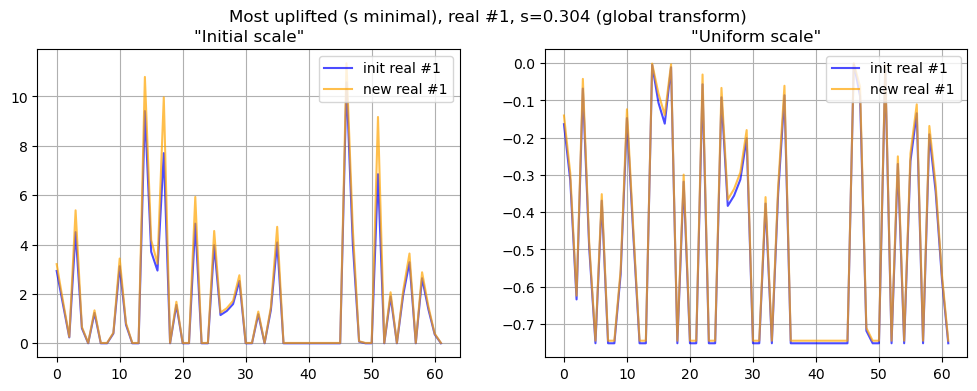

In [16]:
# Plot the most uplifted realization (s minimial)
i = np.where(s_global_real[id_lifted_global_real] == s_global_real[id_lifted_global_real].min())[0][0] 
id = id_lifted_global_real[i]

plt.subplots(1,2,figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(x_real[id], c='blue', alpha=.7, label=f'init real #{id}')
plt.plot(x_new_global_real[id], c='orange', alpha=.7, label=f'new real #{id}')
plt.legend(loc=1)
plt.grid()
plt.title('"Initial scale"')

plt.subplot(1,2,2)
plt.plot(xU_global_real[id], c='blue', alpha=.7, label=f'init real #{id}')
plt.plot(xU_new_global_real[id], c='orange', alpha=.7, label=f'new real #{id}')
plt.legend(loc=1)
plt.grid()
plt.title('"Uniform scale"')

plt.suptitle(f'Most uplifted (s minimal), real #{id}, s={s_global_real[id]:.3g} (global transform)')

plt.show()

In [17]:
# Concatenate realizations of the same length
x_new_global_d = [item for sublist in x_new_global_real for item in sublist]

In [18]:
#Create image of the enriched data
nz, nx, ny = len(x_new_global_d), 1, 1 # set grid dimensions
sx, sy, sz = 1., 1., 1.
ox, oy, oz = 0., 0., 0.

im_new = gn.img.Img(nx, ny, nz, sx, sy, sz, ox, oy, oz, nv=1, val=x_new_global_d, varname=['P10'])

#Export new image
gn.img.writeImageGslib (im_new,'data/lift.gslib')